In [26]:
import numpy as np
import os
import ipynbname
script_dir = os.getcwd()
filename = ipynbname.name()

from sde.SDE_ARFF_lib import (
    SDEARFFTrain,
    NNHyperparameters
)

from sde.experiment_reports_owen import (
    PlotResults,
    sample_data,
    mean_min_loss,
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
# notebook parameters
n_dimensions = 1
step_size = 1e-2
n_pts = 10000
n_subsample = 10

random_seed = 1


In [28]:
# true functions parameters
def true_drift(x):
    result = -(4 * x**3 - 8 * x + 3) / 2
    return result.reshape(-1, 1)


def true_diffusion(x):
    result = (0.1 * x + 1) * 0.5
    return result.reshape(-1, 1)


def true_drift_diffusion(x):
    return true_drift(x), true_diffusion(x)


xlim = np.array([[-2, 2]])

step_sizes = np.zeros((n_pts,)) + step_size


In [29]:
# network parameters
validation_split = .1
ARFF_validation_split = .1

drift_param = NNHyperparameters(K=2**6, 
                                M_min=20,
                                M_max=300,
                                lambda_reg=2e-3,
                                gamma=1,
                                delta=0.1,
                                name='drift')
diff_param = NNHyperparameters(K=drift_param.K,
                               M_min=drift_param.M_min,
                               M_max=drift_param.M_max,
                               lambda_reg=drift_param.lambda_reg,
                               gamma=drift_param.gamma,
                               delta=drift_param.delta,
                               name='diff')


In [30]:
# calculate theoretical mean min loss (integral over loss function)
mean_min_loss(true_diffusion, n_pts, validation_split, step_size, xlim)


Theoretical mean min loss: -1.5835419673390345
Loss standard deviation: 0.007453559924999299
Validation loss standard deviation: 0.022360679774997897


drift epoch: 53


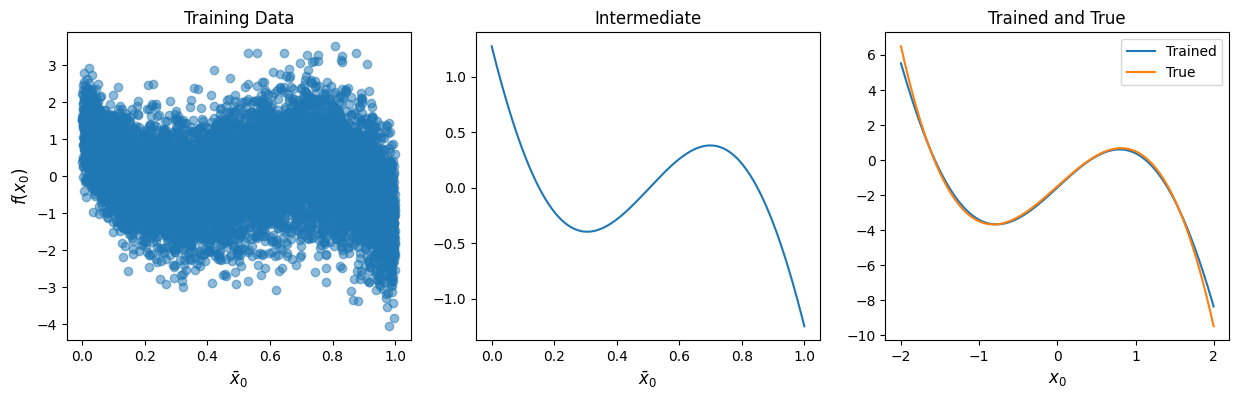

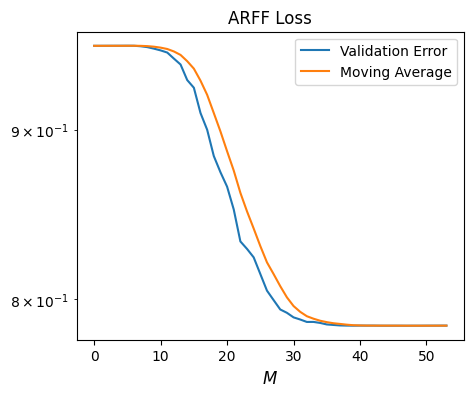

diff epoch: 20


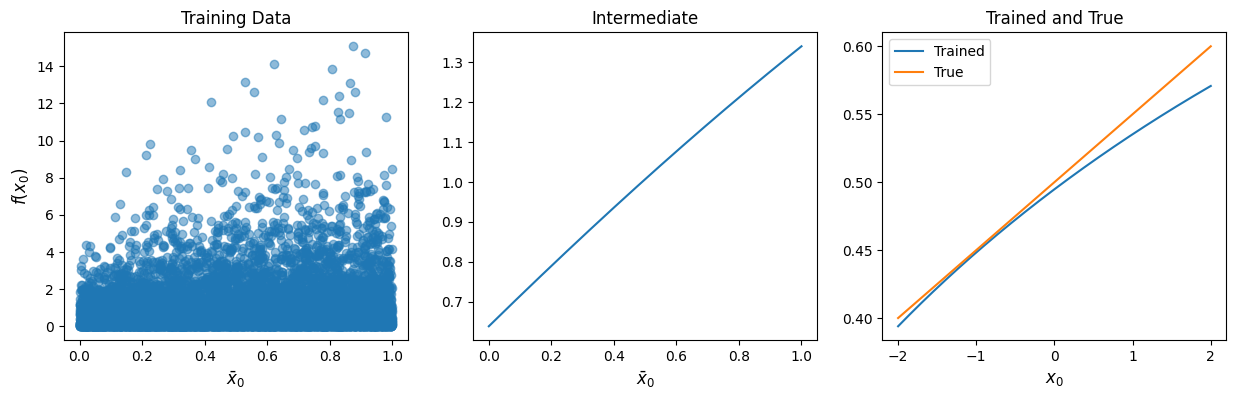

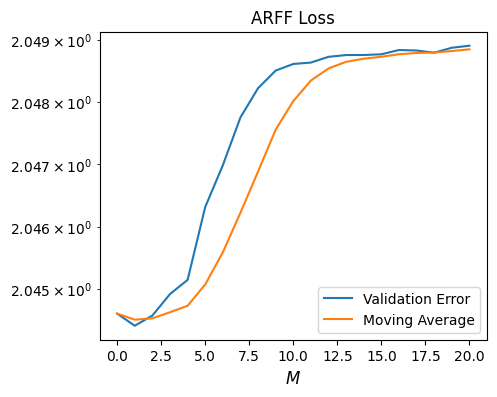

Observed loss: -1.6032480417435986
Observed validation loss: -1.5646457660169422
True function validation loss: -1.5303170026783386
Training time: 3.7888379096984863
drift epoch: 81


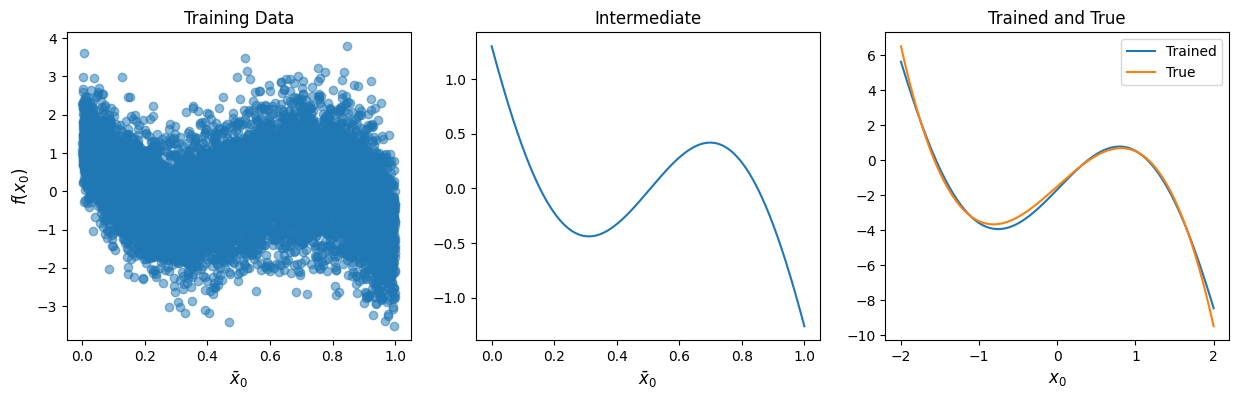

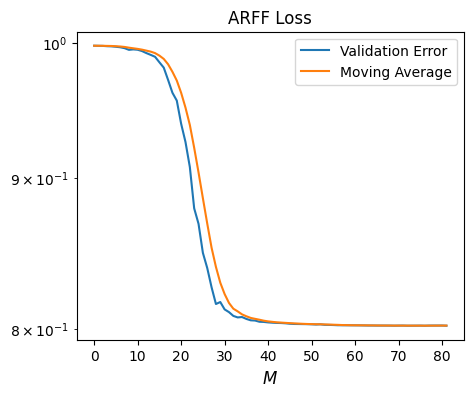

diff epoch: 20


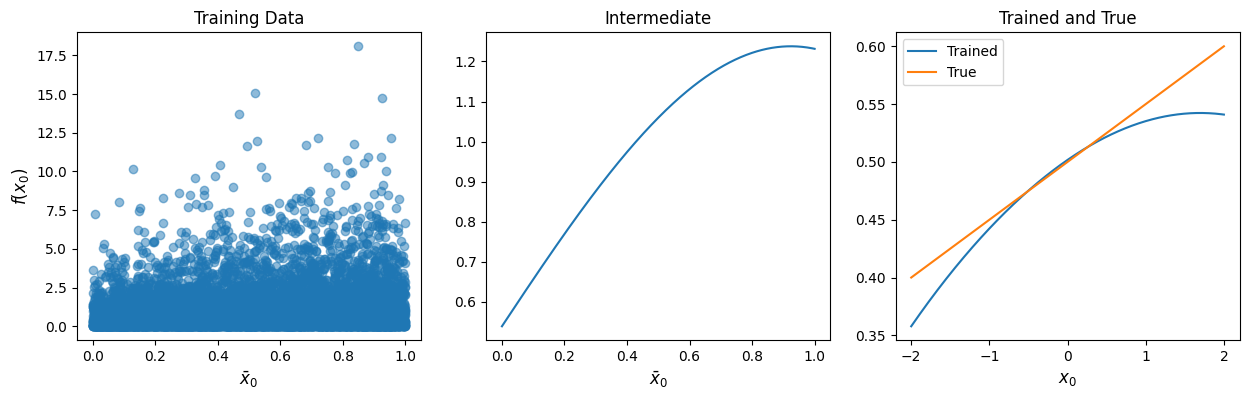

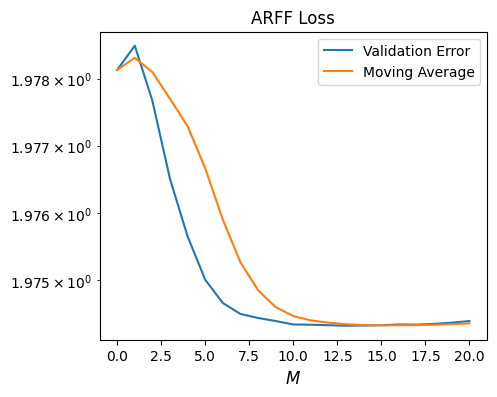

Observed loss: -1.6152000263222006
Observed validation loss: -1.6014490024843309
True function validation loss: -1.5624843862918365
Training time: 6.828194856643677
drift epoch: 52


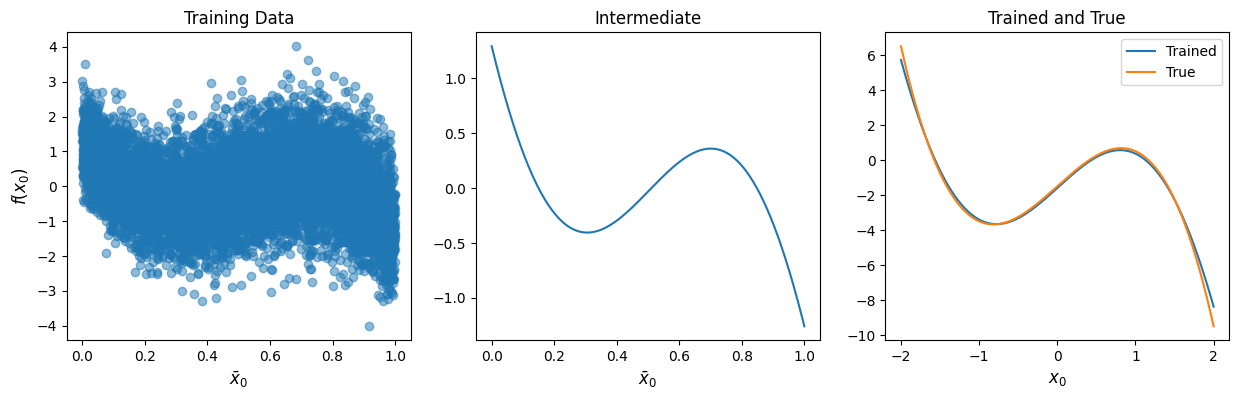

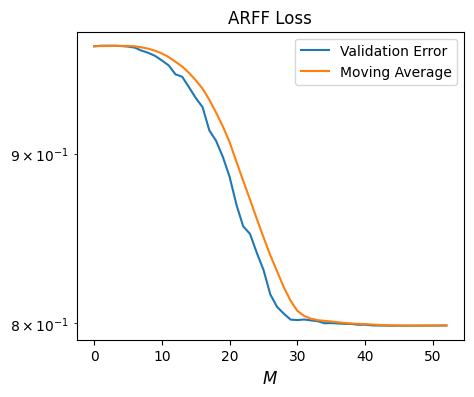

diff epoch: 39


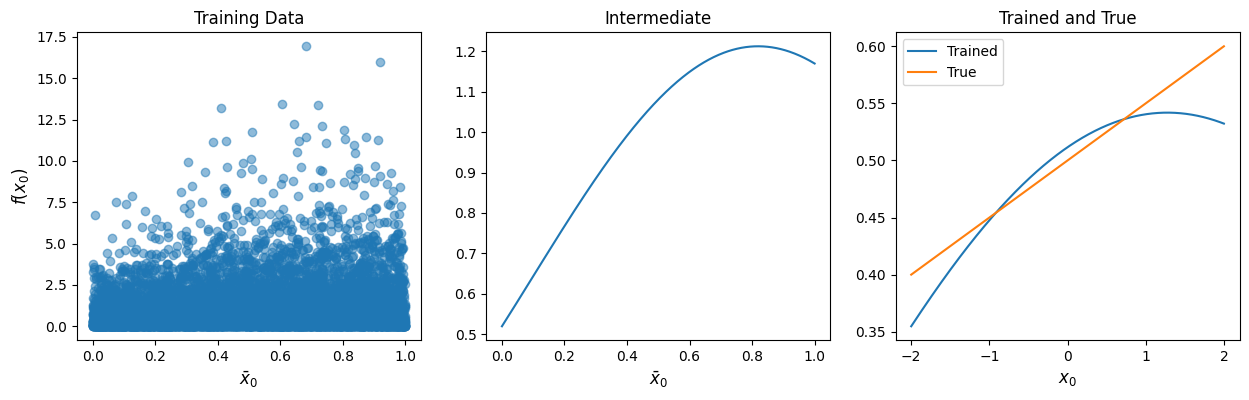

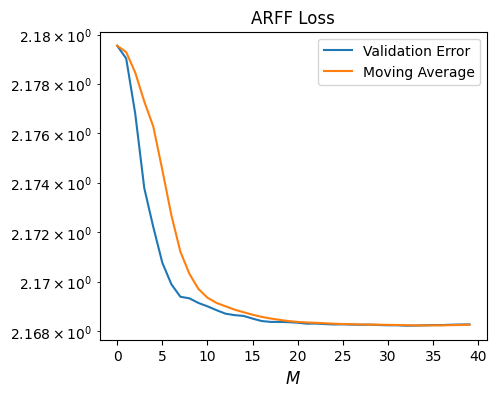

Observed loss: -1.6065454485608937
Observed validation loss: -1.5871696150904095
True function validation loss: -1.566673859927515
Training time: 5.730543375015259
drift epoch: 87


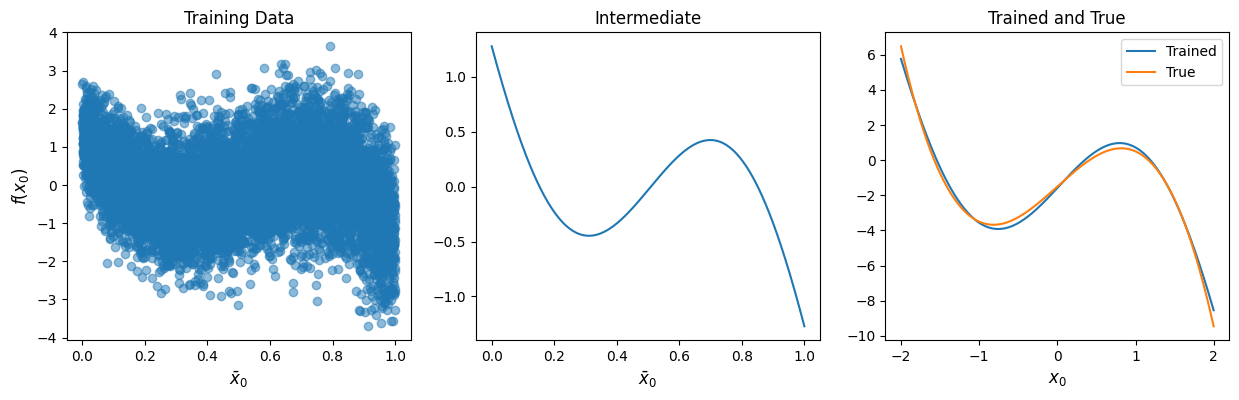

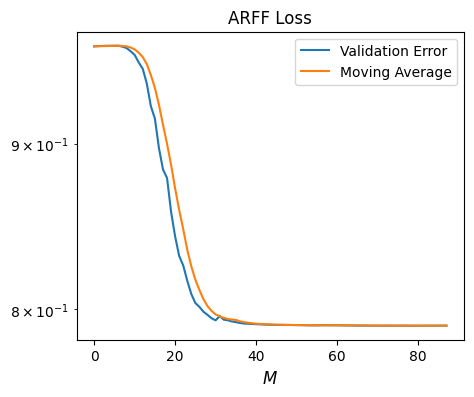

diff epoch: 20


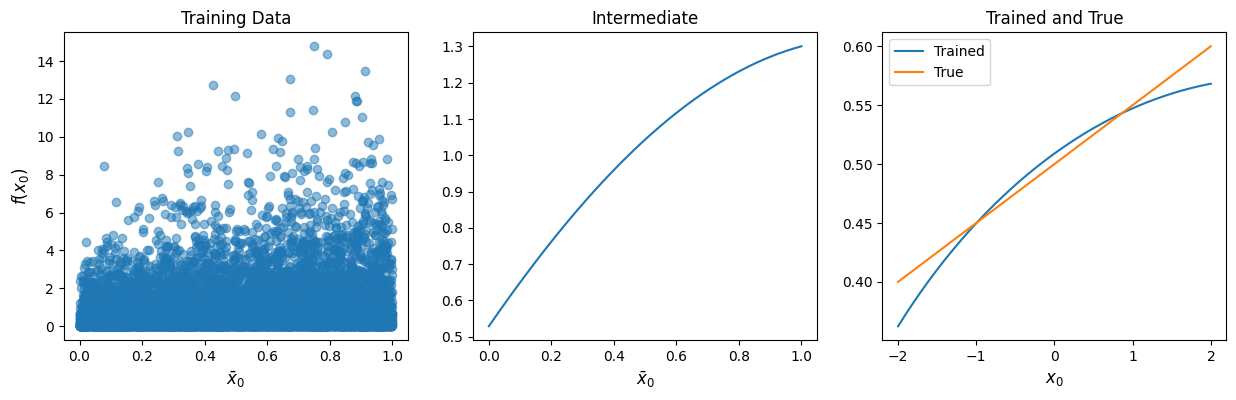

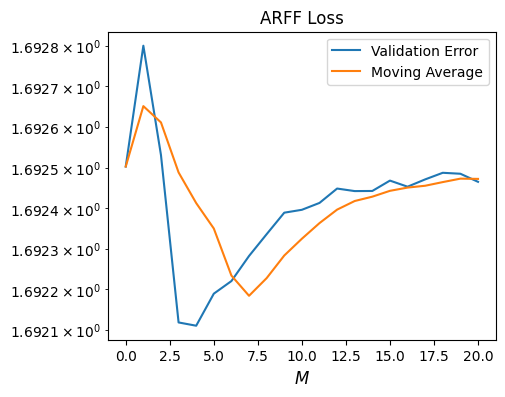

Observed loss: -1.5951617045887057
Observed validation loss: -1.639986182569375
True function validation loss: -1.6255291990664136
Training time: 6.369796276092529
drift epoch: 48


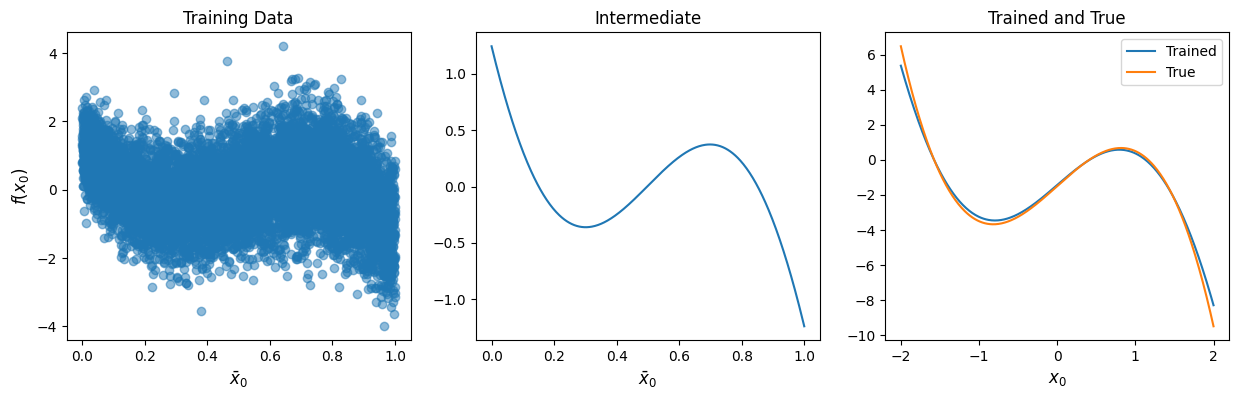

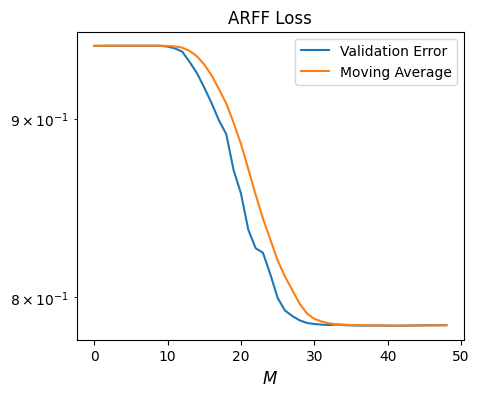

diff epoch: 31


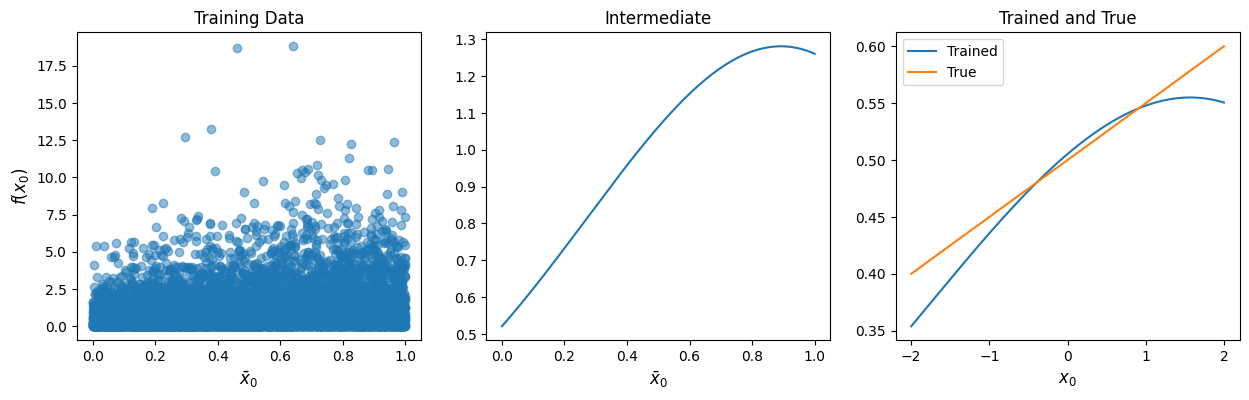

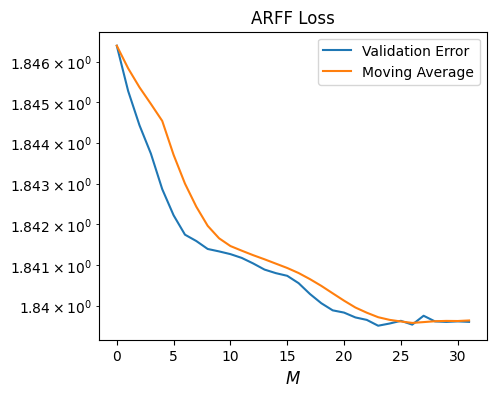

Observed loss: -1.6145874423116677
Observed validation loss: -1.6243352175951062
True function validation loss: -1.6085242699768292
Training time: 4.996015787124634
drift epoch: 51


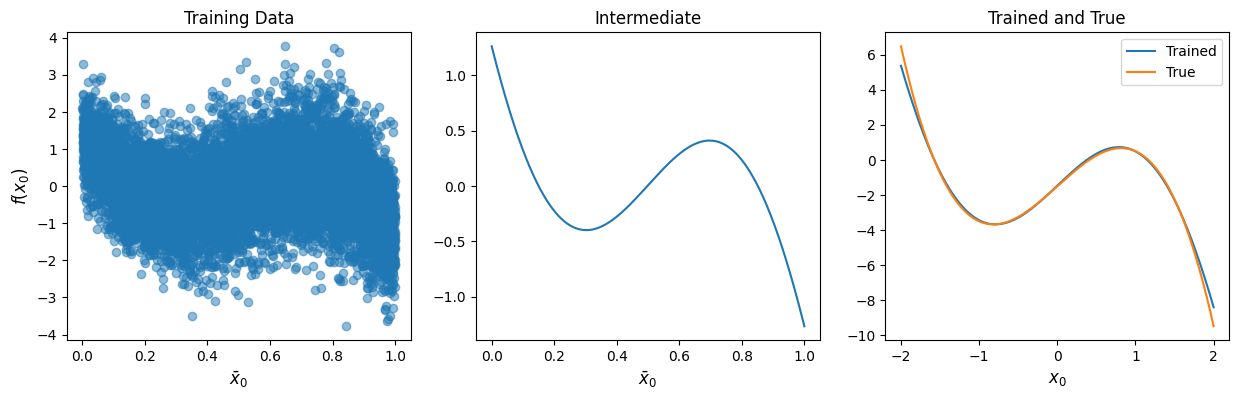

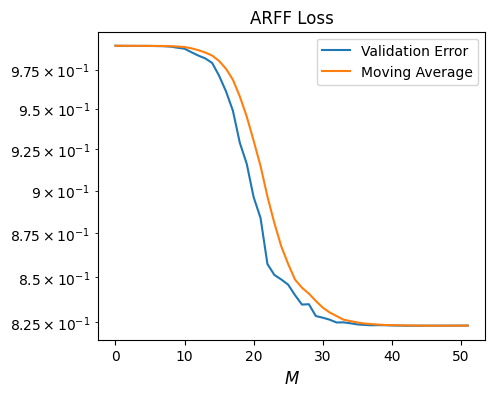

diff epoch: 122


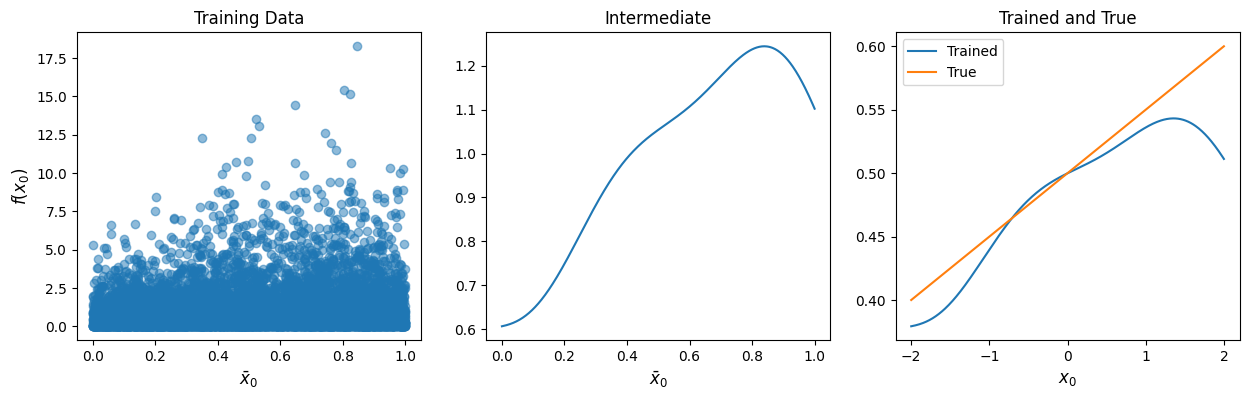

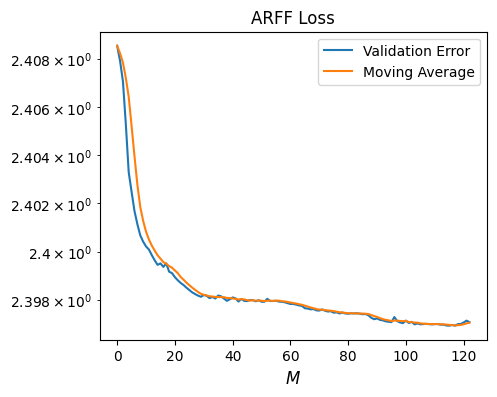

Observed loss: -1.616093999040785
Observed validation loss: -1.6072366421103834
True function validation loss: -1.5852574411203235
Training time: 12.032785415649414
drift epoch: 47


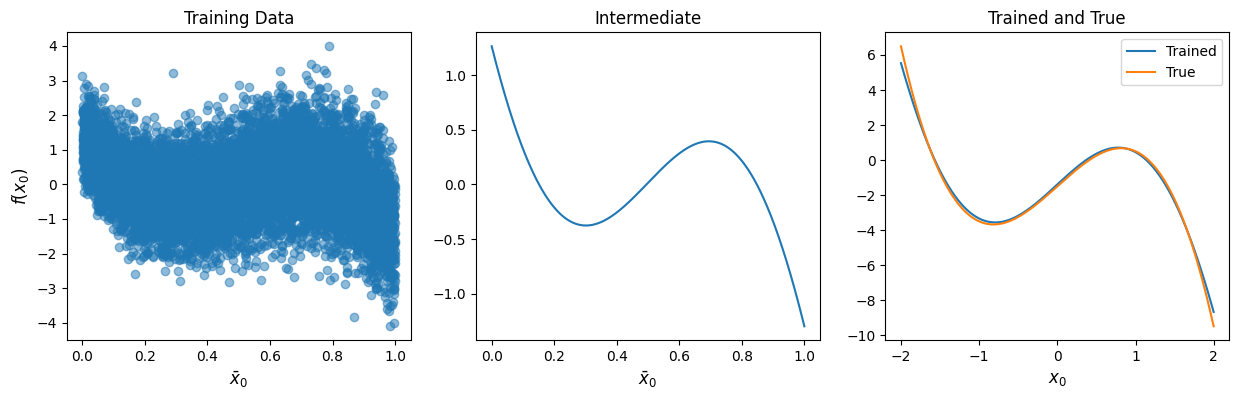

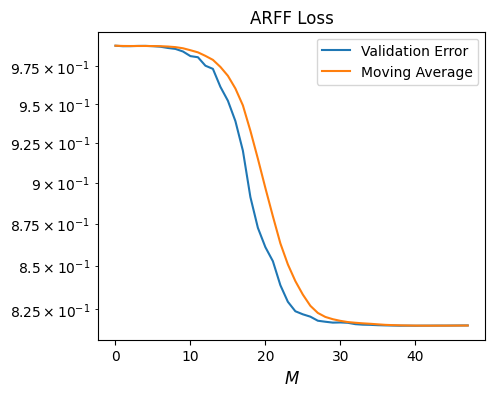

diff epoch: 34


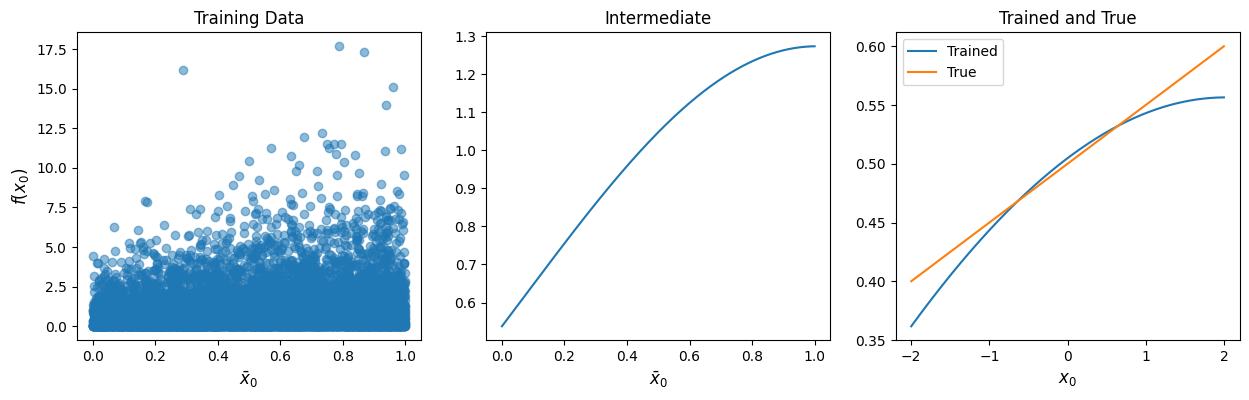

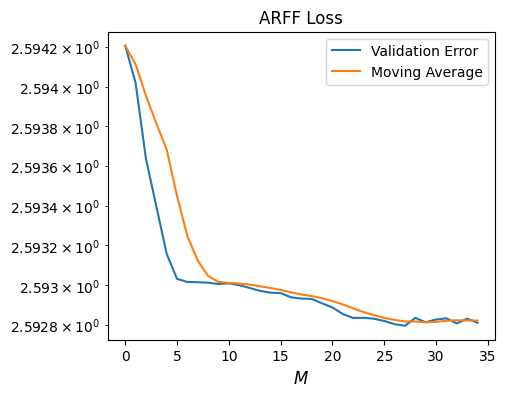

Observed loss: -1.6050941171492568
Observed validation loss: -1.5787892956007337
True function validation loss: -1.562674156360598
Training time: 5.0625
drift epoch: 45


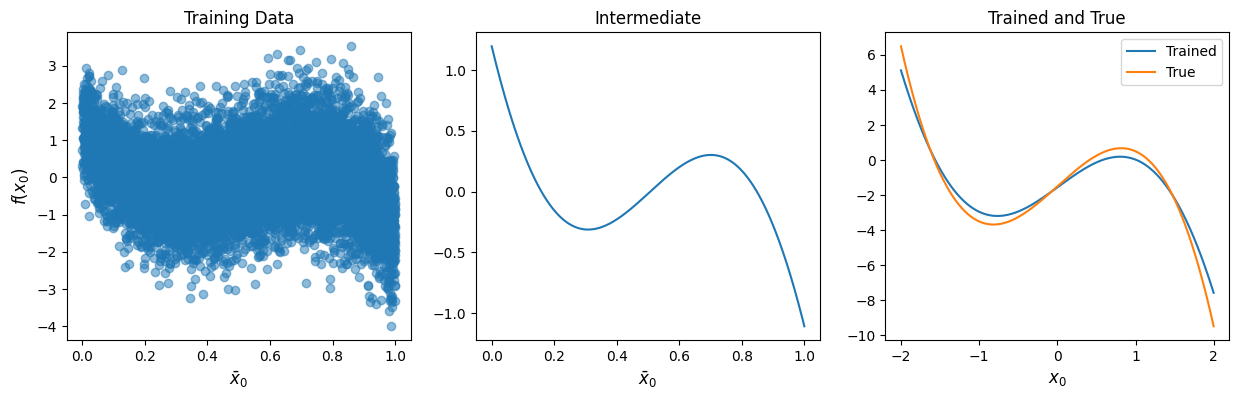

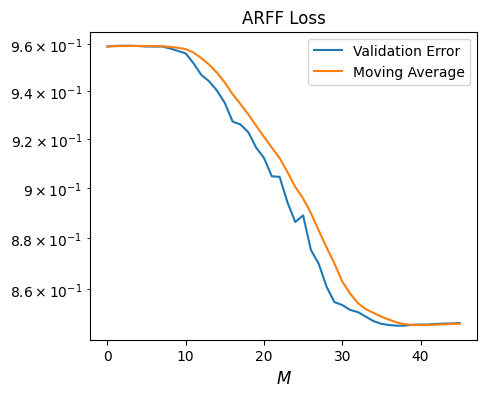

diff epoch: 27


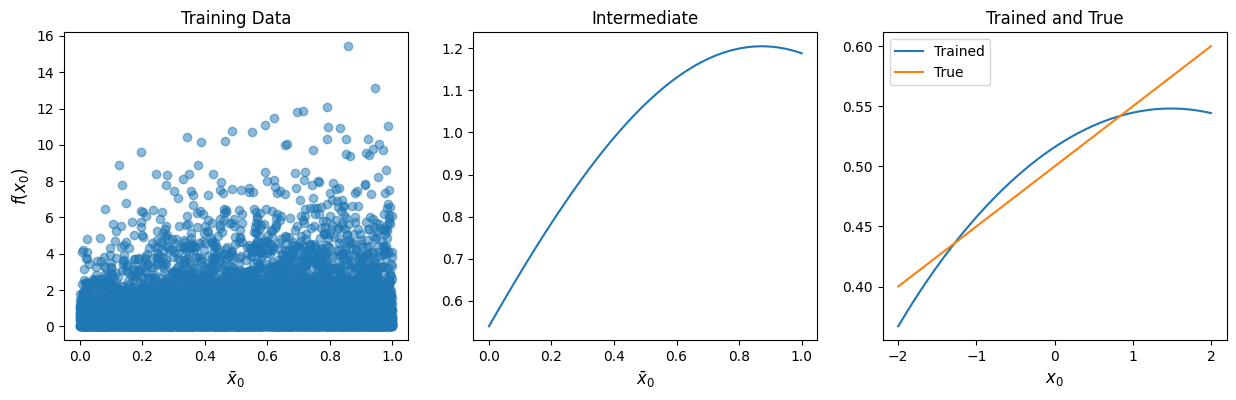

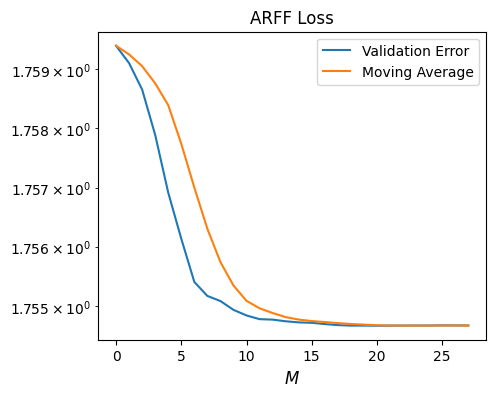

Observed loss: -1.5894764756424387
Observed validation loss: -1.6233927300479478
True function validation loss: -1.6008939885027
Training time: 4.255718946456909
drift epoch: 68


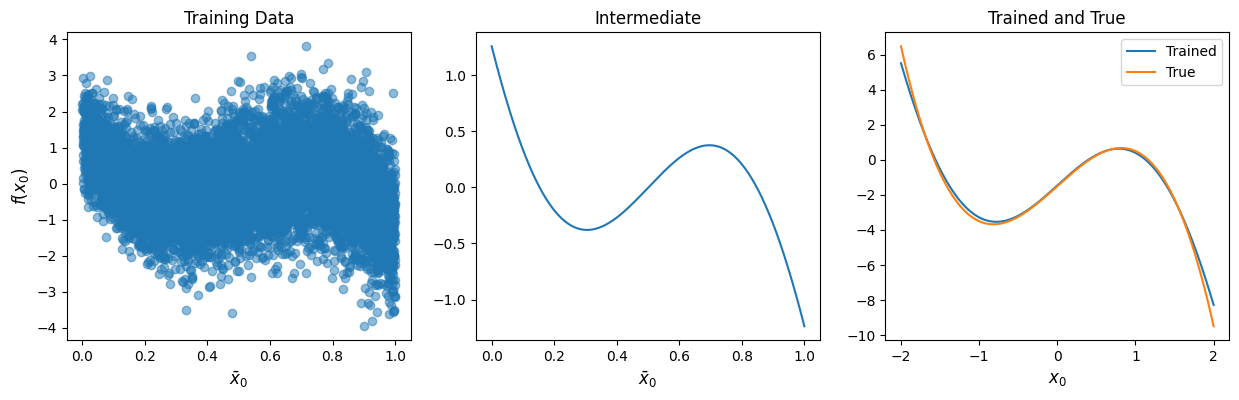

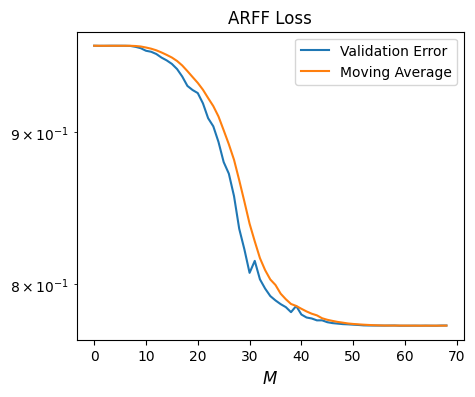

diff epoch: 20


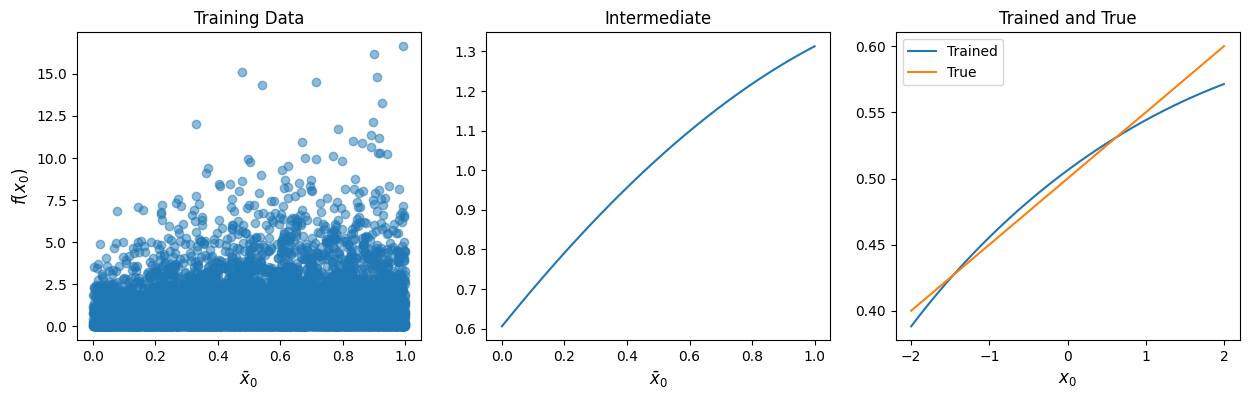

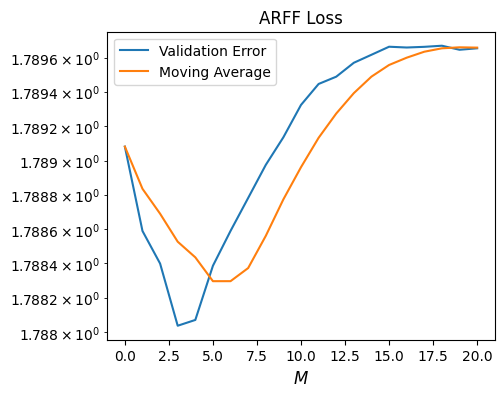

Observed loss: -1.5925081604343816
Observed validation loss: -1.6060025500018702
True function validation loss: -1.5943184578231167
Training time: 4.783639907836914
drift epoch: 61


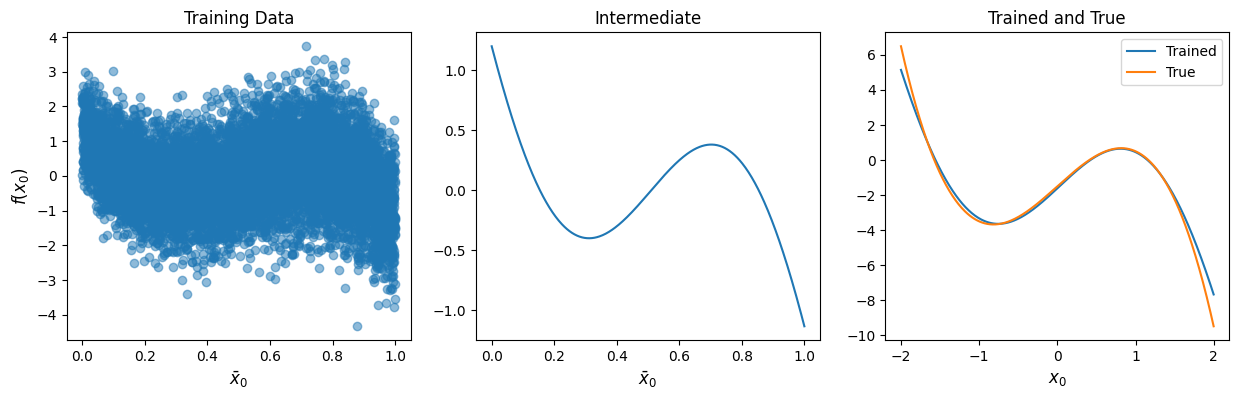

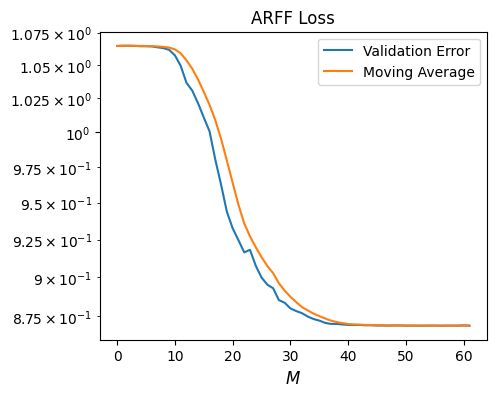

diff epoch: 34


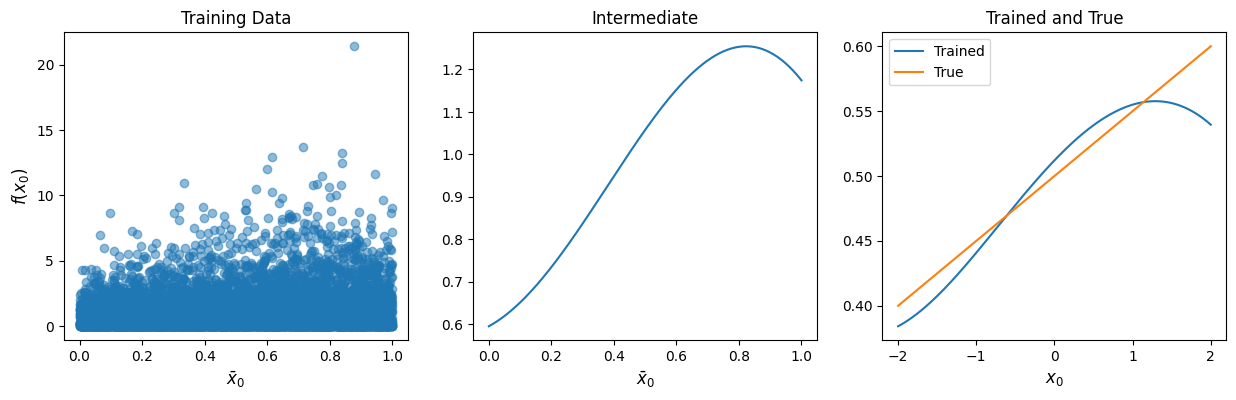

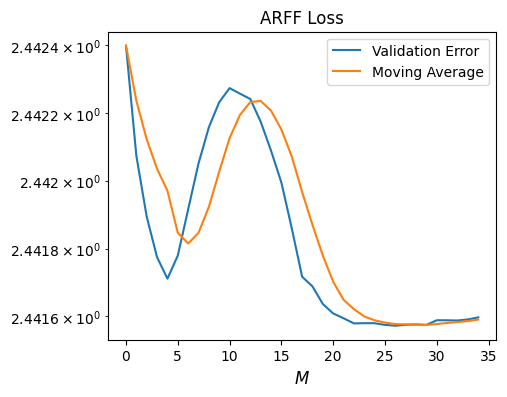

Observed loss: -1.5951846496986783
Observed validation loss: -1.573129472987394
True function validation loss: -1.5427088874940686
Training time: 6.3151655197143555


In [35]:
No_of_tests = 10
training_time = np.zeros(No_of_tests)
val_loss = np.zeros(No_of_tests)

for i in range(No_of_tests):
    rng = np.random.default_rng(random_seed + i)
    x_data, y_data, _ = sample_data(true_drift_diffusion, step_size, n_pts, n_subsample, rng, xlim)
    
    SAT = SDEARFFTrain(n_dimensions=n_dimensions, rng=rng, resampling=True)
    hist = SAT.train_model(drift_param, diff_param, true_drift, true_diffusion, x_data, y_data, step_sizes=step_sizes, validation_split=validation_split, ARFF_validation_split=ARFF_validation_split, plot=True)
    
    training_time[i] = hist.history["training_time"]
    val_loss[i] = hist.history["val_loss"]

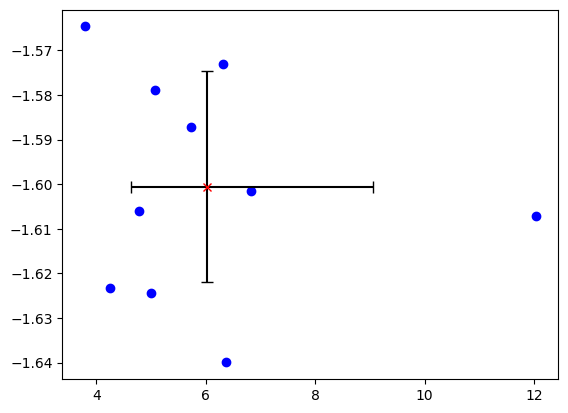

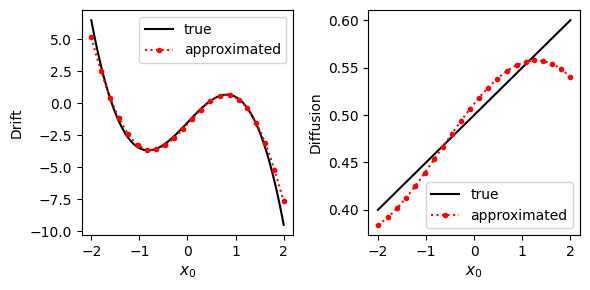

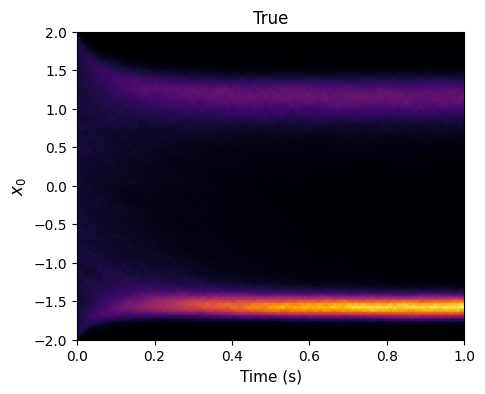

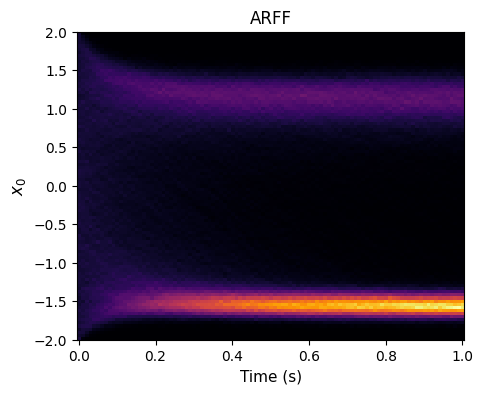

In [37]:
# display and save plots
PR = PlotResults(script_dir=script_dir, filename=filename, n_subsample=n_subsample)

if No_of_tests > 1:
    PR.loss_stats(training_time, val_loss, save=False)

PR.plot_results_functions(SAT.drift_diffusion, true_drift_diffusion, x_data, save=False)

time = 100*step_size
PR.plot_histogram(true_drift_diffusion, step_size/n_subsample, time, rng, xlim, name='True', save=False)
PR.plot_histogram(SAT.drift_diffusion, step_size, time, rng, xlim, name='ARFF', save=False)
